In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Build Your Own AI Podcasting Agent with LangGraph & Gemini
## AI-Powered Podcast Creation with Automated Research, Writing, and Refinement

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/orchestration/langgraph_gemini_podcast.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Forchestration%2Flanggraph_gemini_podcast.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/orchestration/langgraph_gemini_podcast.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/orchestration/langgraph_gemini_podcast.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
| Author(s) | [Kristopher Overholt](https://github.com/koverholt/) |

## Overview

Creating a podcast can be a very involved process, requiring extensive research, writing, editing, and production. **What if there was a way to leverage the power of AI to streamline the creation of a podcast, automating many of the tasks traditionally performed by humans?** [NotebookLM](https://notebooklm.google.com/), for example, lets users easily generate [audio overviews based on documents](https://blog.google/technology/ai/notebooklm-audio-overviews/).

<h4>🔈🔈 <a href="https://storage.googleapis.com/github-repo/generative-ai/gemini/orchestration/langgraph/gemini-podcast.mp3">Listen to a sample podcast generated by this notebook!</a> 🔈🔈</h4>

But what if you want to customize the length of the podcast, the voices, or the conversation flow and augment it with additional research tools? In this notebook, **you'll recreate this kind of podcast generation functionality by building an AI agent to do the heavy lifting and then customize the entire flow yourself!**

**This notebook demonstrates how to build a [LangGraph](https://langchain-ai.github.io/langgraph/)-powered AI agent to research, write, and refine a podcast script using the [Gemini API in in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models).** You'll use LangGraph and LangChain to orchestrate calls to Gemini along with calls to different search tools, allowing the AI to learn about a given topic before writing about it. Then, the AI will critique its work and iterate on the podcast script, improving it with each revision.

Here's how you'll build and use our AI podcasting agent:

- **[User]** Define the podcast topic: Provide a clear and concise topic for the podcast.
- **[Agent]** Generate an outline: Use Gemini to create a high-level outline, structuring the podcast's flow.
- **[Agent]** Conduct research: The AI agent will use search tools like arXiv, PubMed, and Wikipedia to gather relevant information.
- **[Agent]** Write a script: Gemini will generate an engaging podcast script, incorporating the research findings.
- **[Agent]** Critique and iterate: The agent will analyze its script, provide a critique, then generate a revised draft.
- **[Agent]** Generate audio: You'll use text-to-speech to generate audio for each line of the podcast script.

<img src="https://storage.googleapis.com/github-repo/generative-ai/gemini/orchestration/langgraph/gemini-podcast-agent.jpg" width="400px">

## Get started

This section sets up the environment for the AI podcast agent. This includes:

- **Installing Libraries:**  Installing the required Python libraries
- **Restarting Runtime (Colab Only):**  Restarting the Colab runtime
- **Authenticating Environment (Colab Only):**  Authenticating to Google Cloud
- **Setting Project Information:**  Setting up your Google Cloud project

### Install Vertex AI SDK and other required packages

This code cell installs the necessary Python libraries for running the AI podcast agent.

In [2]:
%pip install -q -U \
    arxiv \
    google-cloud-texttospeech \
    langgraph \
    langchain-google-vertexai \
    langchain-community \
    pydub \
    pymupdf \
    wikipedia \
    xmltodict

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [3]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [4]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [5]:
import os

import vertexai

PROJECT_ID = "[your-project-id]"  # @param {type:"string", isTemplate: true}
if PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Building the AI podcasting agent

This section constructs the AI agent. Key steps include:

- **Initializing Agent Memory and State:** Setting up the agent's memory and defining its data structure
- **Initializing the Gemini Model:**  Loading the Gemini language model from Vertex AI
- **Defining Search Tools:**  Creating tools to access information sources like arXiv, PubMed, and Wikipedia
- **Defining Workflow Stages:** Defining each stage of the workflow, including prompts and functions
- **Compiling the Workflow:**  Structuring the workflow as a graph using LangGraph

### Import libraries

This section imports the necessary libraries for LangGraph, LangChain, Vertex AI, and other utilities needed for your agent's functionality.

This includes tools for interacting with the Gemini API, defining custom tools, managing agent state, and displaying results.

In [6]:
# Common libraries
import logging
import os
import re

# Typing utilities for data validation and schema definitions
from typing import TypedDict

from IPython.display import Audio, Image

# Libraries for text-to-speech generation and audio processing
from google.cloud import texttospeech
from langchain.schema.document import Document

# Tools
from langchain_community.retrievers import (
    ArxivRetriever,
    PubMedRetriever,
    WikipediaRetriever,
)

# LangChain and LangGraph components for message handling and tool integration
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool

# LangChain integrations for Gemini API in Google AI Studio and Vertex AI
from langchain_google_vertexai import ChatVertexAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode
from pydub import AudioSegment

# Set logging level to ERROR to filter warnings
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

### Initialize agent memory and agent state

Here, you initialize your [agent's memory](https://langchain-ai.github.io/langgraph/how-tos/memory/manage-conversation-history/) to store information during the workflow.

You also define the schema for your [agent's state](https://langchain-ai.github.io/langgraph/how-tos/state-model/), which includes the podcast outline, search queries, and drafts.

In [7]:
# Initialize agent memory
memory = MemorySaver()


# Define the agent's state
class AgentState(TypedDict):
    revision_number: int
    max_revisions: int
    search_count: int
    max_searches: int
    task: str
    outline: str
    queries: list
    content: list
    draft: str
    critique: str
    tool_calls: list

### Initialize Gemini model

Initialize the Gemini model from Vertex AI, specifying the model version and temperature settings.

This sets up the core language model that will power your agent's actions.

In [8]:
model = ChatVertexAI(model="gemini-1.5-pro", temperature=0)

### Define search tools

This section defines custom tools that will be used by your AI podcast agent to gather information from various sources. These tools act as interfaces to external services and provide access to relevant data for the podcast topic.

Each tool is implemented as a Python function decorated with the `@tool` decorator from LangChain. This decorator makes it easy to integrate these functions into LangGraph workflows.

The following search tools are defined:

- **search_arxiv:** Retrieves research papers from arXiv based on a keyword query.
- **search_pubmed:** Searches for information on PubMed, a database of biomedical literature.
- **search_wikipedia:** Fetches information from Wikipedia based on a keyword query.

Your LangGraph application will use these tool nodes to call the corresponding search functions and obtain information from these external sources. This allows the AI agent to learn about the podcast topic before generating the script.

In [9]:
@tool
def search_arxiv(query: str) -> list[Document]:
    """Search for relevant publications on arXiv"""
    retriever = ArxivRetriever(
        load_max_docs=2,
        get_full_documents=True,
    )
    docs = retriever.invoke(query)
    if docs:
        return docs
    else:
        return ["No results found on arXiv"]


@tool
def search_pubmed(query: str) -> list[Document]:
    """Search for information on PubMed"""
    retriever = PubMedRetriever()
    docs = retriever.invoke(query)
    if docs:
        return docs
    else:
        return ["No results found on PubMed"]


@tool
def search_wikipedia(query: str) -> list[Document]:
    """Search for information on Wikipedia"""
    retriever = WikipediaRetriever()
    docs = retriever.invoke(query)
    if docs:
        return docs
    else:
        return ["No results found on Wikipedia"]

### Define workflow stages along with corresponding prompts and functions

This section defines the different stages of the AI podcast agent's workflow and the corresponding prompt templates and node functions that drive each stage.

Each stage represents a specific task in the podcast creation process, such as generating an outline, conducting research, writing the script, and providing a critique.

For each stage, you'll define:

- **Prompt Template:** A carefully crafted text prompt that instructs the Gemini language model on what to do at that stage. The prompt provides context, instructions, and any necessary input data.
- **Node Function:** A Python function that encapsulates the logic for executing that stage. The function typically involves:
    - Constructing the prompt with relevant information from the agent's state.
    - Invoking the Gemini API with the prompt.
    - Processing the model's response and updating the agent's state.

These prompt templates and node functions are the building blocks of the LangGraph workflow that orchestrates the entire podcast creation process.

#### Podcast outline node

This node generates a structured outline for the podcast based on the user-provided topic:

In [10]:
OUTLINE_PROMPT = """You are an expert writer tasked with writing a high level outline of an engaging 2-minute podcast.
Write such an outline for the user provided topic. Give an outline of the podcast along with any
relevant notes or instructions for the sections."""


# Generate an outline for the podcast based on the user-provided topic
def podcast_outline_node(state: AgentState):
    messages = [
        SystemMessage(content=OUTLINE_PROMPT),
        HumanMessage(content=state["task"]),
    ]
    response = model.invoke(messages)
    return {"outline": response.content}

#### Research plan node

This node formulates a search query based on the podcast topic and previous queries:

In [11]:
RESEARCH_PLAN_PROMPT = """You are a researcher tasked with providing information that can
be used when writing the following podcast. Generate one search query consisting of a few
keywords that will be used to gather any relevant information. Do not output any information
other than the query consisting of a few words.

These were the past queries, do not repeat keywords from past queries in your newly generated query:
---
{queries}"""


# Generates a search query based on the outline
def research_plan_node(state: AgentState):
    messages = [
        SystemMessage(content=RESEARCH_PLAN_PROMPT.format(queries=state["queries"])),
        HumanMessage(content=state["task"]),
    ]
    response = model.invoke(messages)
    queries = state["queries"]
    if queries:
        queries.append(response.content)
    else:
        queries = [response.content]
    return {"queries": queries}

#### Research task node

This node executes a search using the selected tool and query, retrieving relevant information for the podcast:

In [12]:
RESEARCH_TASK_PROMPT = """Use the available search tools and search queries to find information
relevant to the podcast. Try searching different sources to obtain different articles. Try using
different search tools than what was used previously so that you can obtain a broader range of
information.

These are the previous tool calls, so you can choose a different tool:
---
{tool_calls}
---
These are the previous search results, so you can aim for different sources and content:
---
{content}"""


# Performs searches using tools
def research_agent_node(state: AgentState):
    tool_calls = state["tool_calls"]
    content = state["content"]
    queries = state["queries"]
    query = queries[-1]
    messages = [
        SystemMessage(
            content=RESEARCH_TASK_PROMPT.format(tool_calls=tool_calls, content=content)
        ),
        HumanMessage(content=query),
    ]

    # Perform function calls
    tools = [search_arxiv, search_pubmed, search_wikipedia]
    model_with_tools = model.bind_tools(tools)
    response_tool_calls = model_with_tools.invoke(messages)
    if tool_calls:
        tool_calls.append(response_tool_calls)
    else:
        tool_calls = [response_tool_calls]

    # Defines a tool node based on search functions
    tool_node = ToolNode(tools)
    response = tool_node.invoke({"messages": [response_tool_calls]})

    # Add the search results to the content list in the agent state
    for message in response.get("messages", []):
        if isinstance(message, ToolMessage):
            content.insert(0, message.content)

    return {
        "content": content,
        "tool_calls": tool_calls,
        "search_count": state["search_count"] + 1,
    }


# Determine whether to continue research based on the number of searches performed
def should_continue_tools(state: AgentState):
    if state["search_count"] > state["max_searches"]:
        return "generate_script"
    else:
        return "research_plan"

#### Podcast writing node

This node generates a draft podcast script using the outline and research results, aiming for an engaging and informative style:

In [13]:
WRITER_PROMPT = """
You are a writing assistant tasked with writing engaging 2-minute podcast scripts.

- Generate the best podcast script possible for the user's request and the initial outline.
- The script MUST strictly alternate lines between the two hosts, separating each host's line with a newline.
- Add an intro phrase and outro phrase to start and end the podcast, and use a fun, random name for the podcast show.
- Given a critique, respond with a revised version of your previous script.
- Include lively back-and-forth chatter, reflections, and expressions of amazement between the hosts.
- Cite at least THREE pieces of research throughout the script, choosing the most relevant research for each point.
- DO NOT include ANY of the following:
    - Speaker labels (e.g., "Host 1:", "Host 2:")
    - Sound effect descriptions (e.g., "[Sound of waves]")
    - Formatting instructions (e.g., "(Emphasis)", "[Music fades in]")
    - Any other non-dialogue text.
- Use this format for citations, including the month and year if available:
    "In [Month, Year], [Organization] found that..."
    "Research from [Organization] in [Month, Year] showed that..."
    "Back in [Month, Year], a study by [Organization] suggested that..."
---
Utilize all of the following search results and context as needed:
{content}
---
If this is a revision, the critique will be provided below:
{critique}"""


# Generates a draft of the script based on the content and outline
def generate_script_node(state: AgentState):
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(
                content=state["content"], critique=state.get("critique", "")
            )
        ),
        HumanMessage(
            content=f"{state['task']}\n\nHere is my outline:\n\n{state['outline']}"
        ),
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "search_count": 0,  # Reset the search count for the next revision
        "revision_number": state.get("revision_number", 1) + 1,
    }

#### Podcast critique node

This node provides feedback and suggestions for improvement on the generated podcast script:

In [14]:
CRITIQUE_PROMPT = """You are a producer grading a podcast script.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for conciceness, depth, style, etc."""


# Generates a critique with feedback on the draft podcast script
def perform_critique_node(state: AgentState):
    messages = [
        SystemMessage(content=CRITIQUE_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

#### Research critique node

This node generates a new search query based on the critique of the script, aiming to address weaknesses and find additional information:

In [15]:
RESEARCH_CRITIQUE_PROMPT = """You are a writing assistant tasked with providing information that can
be used when making any requested revisions (as outlined below).
Generate one search query consisting of a few keywords that will be used to gather any relevant
information. Do not output any information other than the query consisting of a few words.

---

These were the past queries, so you can vary the query that you generate:

{queries}
"""


# Generates a new search query based on the critique
def research_critique_node(state: AgentState):
    messages = [
        SystemMessage(
            content=RESEARCH_CRITIQUE_PROMPT.format(queries=state["queries"])
        ),
        HumanMessage(content=state["critique"]),
    ]
    response = model.invoke(messages)
    queries = state.get("queries", [])
    if queries:
        queries.append(response.content)
    else:
        queries = [response.content]
    return {"queries": queries}


# Decide whether to continue to the next revision or end the process
def should_continue(state: AgentState):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "perform_critique"

## Define and compile the LangGraph workflow

This section defines the structure and flow of the AI podcast agent using LangGraph.

The workflow is constructed as a graph with nodes representing each stage in the process (e.g., outlining, research, script generation) and edges defining the transitions between these stages.

The workflow includes two main loops:

- **Research Loop:**  This loop iteratively plans and executes searches until a specified number of searches are completed.
- **Critique and Revision Loop:** This loop handles the script critique, additional research based on the critique, and script revision, repeating for a set number of revisions.

The `workflow.compile()` function transforms this graph definition into an executable workflow, incorporating memory management to maintain the agent's state throughout the process.

In [16]:
# Initialize the state graph
workflow = StateGraph(AgentState)

# Define the nodes of the workflow, representing each stage of the process
workflow.add_node("podcast_outline", podcast_outline_node)
workflow.add_node("research_plan", research_plan_node)
workflow.add_node("research_agent", research_agent_node)
workflow.add_node("generate_script", generate_script_node)
workflow.add_node("perform_critique", perform_critique_node)
workflow.add_node("research_critique", research_critique_node)

# Specify the starting node of the workflow
workflow.set_entry_point("podcast_outline")

# Define the flow between node and stages
workflow.add_edge("podcast_outline", "research_plan")
workflow.add_edge("research_plan", "research_agent")
workflow.add_edge("perform_critique", "research_critique")
workflow.add_edge("research_critique", "research_agent")

# Define conditional edges for the research loop
workflow.add_conditional_edges(
    "research_agent",
    should_continue_tools,
    {"generate_script": "generate_script", "research_plan": "research_plan"},
)

# Define conditional edges for the critique and revision loop
workflow.add_conditional_edges(
    "generate_script",
    should_continue,
    {END: END, "perform_critique": "perform_critique"},
)

# Compile the workflow graph, enabling memory to track agent state
graph = workflow.compile(checkpointer=memory)

### Visualize the workflow

This cell visualizes the compiled LangGraph workflow as a [Mermaid diagram](https://mermaid.js.org/).

The diagram provides a clear and intuitive representation of the workflow's structure, showing the nodes, edges, and the flow of execution.

This visualization helps to understand the overall process and the interactions between different stages of the AI podcast agent.

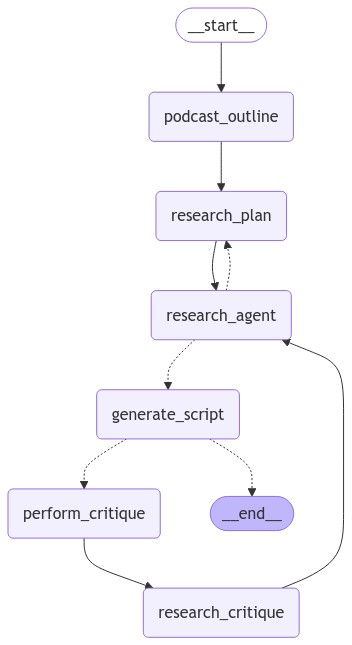

In [17]:
# Display a Mermaid diagram of the workflow
Image(graph.get_graph().draw_mermaid_png())

### Define the podcast topic

This cell defines the topic of the podcast that the AI agent will create.

The topic is assigned to the variable `PODCAST_TOPIC`. Feel free to modify this variable to explore different podcast topics! 

In [18]:
PODCAST_TOPIC = "Explore the use of bio-inspired fluid dynamics in the design of underwater robots and vehicles"

### Run the AI podcast agent

This cell executes the compiled LangGraph workflow, running the AI podcast agent to generate the podcast script. 

The code performs these actions:

- **Clean agent helper function:**  This function prepares the agent's output for printing by removing unnecessary characters and formatting
- **Thread Configuration:**  A thread configuration is defined to ensure a unique history for this workflow execution
- **Workflow Execution:** The `graph.stream()` method runs the workflow, iterating through each stage and updating the agent's state
- **Output Display:** The code prints the results of each stage, including the agent's actions and generated output

In [19]:
# Function to clean and format agent output for display


def clean_agent_result(data):
    agent_result = str(data)
    agent_result = re.sub(
        r"[^\x00-\x7F]+", " ", agent_result
    )  # Remove non-ASCII characters
    agent_result = re.sub(r"\\\\n", "\n", agent_result)  # Replace escaped newlines
    agent_result = re.sub(r"\\n", "", agent_result)  # Replace newlines
    agent_result = re.sub(r"\\'", "'", agent_result)  # Replace escaped single quotes
    return agent_result


# Thread ID for unique history in workflow execution
thread = {"configurable": {"thread_id": "1"}}

# Run the LangGraph workflow, passing the initial state and thread configuration
for state in graph.stream(
    {
        "task": PODCAST_TOPIC,
        "revision_number": 1,  # Current revision number
        "max_revisions": 2,  # Maximum number of revisions allowed
        "search_count": 0,  # Current search number
        "max_searches": 3,  # Maximum number of searches allowed per revision
        "content": [],
        "queries": [],
        "tool_calls": [],
    },
    thread,
):
    # Print a snippet of the results of each workflow stage
    for k, v in state.items():
        print(f"Agent Node: {k}\n")
        print("Agent Result:")
        print(clean_agent_result(v)[:1000])
    print("\n====================\n")

Agent Node: podcast_outline

Agent Result:
{'outline': '##  Diving Deep: How Nature Inspires Underwater Robot Design **Podcast Outline:****I. Introduction (0:00 - 0:20):***   **Hook:** Start with an engaging sound effect (gentle waves, whale song) and a captivating question: "What if we could design underwater robots as efficient and agile as a school of fish?"*   **Introduce topic:** Briefly explain bio-inspired design and its application in underwater robotics.*   **Highlight the episode's focus:** Exploring specific examples of how nature inspires fluid dynamics in underwater robots.**II.  Example 1:  The Grace of Jellyfish (0:20 - 0:45):***   **Introduce the jellyfish:** Describe their unique propulsion mechanism (contracting bell).*   **Connect to robotics:** Explain how scientists are mimicking this mechanism to create more efficient underwater robots.*   **Specific example:**  Mention a real-world robot inspired by jellyfish propulsion (e.g., the "RoboJelly").*   **Benefits:** H

### Parse and display the final podcast script

This section extracts and prepares the final podcast script generated by the AI agent.

It displays the script for review, where each string in the list will be narrated by a different text-to-speech voice.

In [20]:
podcast_script = state["generate_script"]["draft"]
parsed_script = [
    text for text in (line.strip() for line in podcast_script.splitlines()) if text
]
parsed_script

['Welcome to Water World Wonders!',
 "What if we told you the ocean's depths hold the secrets to building better robots?",
 "That's right, we're diving deep into the world of bio-inspired design, where engineers are turning to nature to create the next generation of underwater robots.",
 'Take the jellyfish, for example.',
 'These graceful creatures move with such ease, pulsating their bell-shaped bodies to glide through the water.',
 'In 2012, researchers at Virginia Tech drew inspiration from this to create "RoboJelly," a robot that mimics the jellyfish\'s efficient propulsion.',
 'This design allows for incredible maneuverability in tight spaces, perfect for exploring delicate coral reefs or even shipwrecks.',
 "But nature's brilliance doesn't stop there!",
 'Have you ever wondered how fish swim in schools so effortlessly?',
 'It turns out, by swimming in formation, they create a slipstream that reduces drag and saves energy.',
 'In fact, a study by the University of Groningen in 20

### Generate audio for the podcast

This cell generates audio for each line of the parsed podcast script using Google Cloud's Text-to-Speech API.

It creates separate audio files for each line, alternating between two different voices to simulate a conversation between two podcast hosts.

The code:

1. **Initializes the Text-to-Speech Client:**  Sets up the connection to the API.
2. **Defines Audio Configuration:** Specifies the desired output audio format (MP3).
3. **Iterates through Script Lines:** Generates audio for each line, alternating voices.
4. **Saves Audio Files:**  Writes the generated audio to separate MP3 files.

In [21]:
# Instantiates a client
client = texttospeech.TextToSpeechClient()

# Select the type of audio file you want returned
audio_config = texttospeech.AudioConfig(audio_encoding=texttospeech.AudioEncoding.MP3)

audio_files = []
for count, line in enumerate(parsed_script):
    # Set the text input to be synthesized
    synthesis_input = texttospeech.SynthesisInput(text=line)

    # Choose the voice for the current line, alternating between hosts
    if count % 2 == 0:
        voice_name = "en-US-Journey-O"
    elif count % 2 == 1:
        voice_name = "en-US-Journey-D"

    # Configure voice parameters: language and voice name
    voice = texttospeech.VoiceSelectionParams(
        language_code="en-US",
        name=voice_name,
    )

    # Generate audio using the Text-to-Speech API
    response = client.synthesize_speech(
        input=synthesis_input, voice=voice, audio_config=audio_config
    )

    # Save the generated audio to an MP3 file
    filename = f"part-{str(count)}.mp3"
    audio_files.append(filename)
    with open(filename, "wb") as out:
        out.write(response.audio_content)
        print(f"Audio content written to file {filename}")

Audio content written to file part-0.mp3
Audio content written to file part-1.mp3
Audio content written to file part-2.mp3
Audio content written to file part-3.mp3
Audio content written to file part-4.mp3
Audio content written to file part-5.mp3
Audio content written to file part-6.mp3
Audio content written to file part-7.mp3
Audio content written to file part-8.mp3
Audio content written to file part-9.mp3
Audio content written to file part-10.mp3
Audio content written to file part-11.mp3
Audio content written to file part-12.mp3
Audio content written to file part-13.mp3
Audio content written to file part-14.mp3
Audio content written to file part-15.mp3
Audio content written to file part-16.mp3
Audio content written to file part-17.mp3
Audio content written to file part-18.mp3
Audio content written to file part-19.mp3
Audio content written to file part-20.mp3


### Combine audio files and generate final podcast

This cell combines the individual audio files generated in the previous step into a single podcast file.

It also adds brief silences between each line for better listening experience.

The final podcast is saved as `gemini-podcast.mp3`.

In [22]:
# Initialize audio segment
full_audio = AudioSegment.silent(duration=200)

# Concatenate audio segments with silence in between
for file in audio_files:
    sound = AudioSegment.from_mp3(file)
    silence = AudioSegment.silent(duration=200)
    full_audio += sound + silence
    os.remove(file)  # Remove the individual part files after combining

# Save the final audio output to a file
podcast_filename = "gemini-podcast.mp3"
full_audio.export(podcast_filename)
print(f"Podcast content written to file {podcast_filename}")

Podcast content written to file gemini-podcast.mp3


### Listen to your AI-generated podcast!

This cell plays the final podcast generated by the AI agent.

The `Audio` object from `IPython.display` is used to embed the audio player directly into the notebook. The podcast will start playing automatically.

Enjoy your AI-created podcast!

In [23]:
Audio(filename=podcast_filename, rate=32000, autoplay=True)

## Conclusion: Building AI-powered podcast agents

This notebook showcases the exciting potential of using AI to automate the podcast creation process. By combining the power of the Gemini API with the flexibility of LangGraph, you built an intelligent agent capable of:

- **Generating Podcast Outlines:** Structuring the flow and content of the podcast.
- **Conducting Research:**  Gathering information from various sources like arXiv, PubMed, and Wikipedia.
- **Writing Engaging Scripts:** Crafting podcast scripts with natural-sounding dialogue, citations, and a conversational style.
- **Critiquing and Revising:** Providing feedback on the script and iteratively refining it.
- **Generating Audio:**  Using text-to-speech technology to create the final podcast audio.

This is just a starting point! You can customize this workflow further by:

- **Adding New Research Tools:**  Integrate additional sources of information relevant to your podcast topics.
- **Experimenting with Prompts:** Refine the prompts to guide the AI agent towards your desired style and content.
- **Exploring Different Voices:**  Use a wider range of voices for the podcast hosts to create unique and engaging listening experiences.

The possibilities are endless! As AI technology continues to advance, you can expect even more creative and innovative applications in podcasting and other content creation domains.

You can learn more about [LangGraph](https://langchain-ai.github.io/langgraph/), the [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models), or the [chat model provider for Vertex AI in LangChain](https://python.langchain.com/docs/integrations/chat/google_vertex_ai_palm/) in their respective documentation pages.